# Compare static vs dynamic communities

We believe that, when looking at reactions on an article, the reactions will be a derivation of some degree from the following/ignoring Graphs 

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import read_graph
import viz
import utils

In [22]:
df = pd.read_csv("../data/raw/Following_Ignoring_Relationships_01052019_31052019.csv", delimiter=";")
fol_df = df[df["ID_CommunityConnectionType"]==1]
fol_df = fol_df[fol_df["ID_CommunityIdentity"] != fol_df["ID_CommunityIdentityConnectedTo"]] # remove self followers
G_fol = nx.from_pandas_edgelist(fol_df, source="ID_CommunityIdentity", target="ID_CommunityIdentityConnectedTo",
                               create_using=nx.DiGraph)
ign_df = df[df["ID_CommunityConnectionType"]==2]
G_ign = nx.from_pandas_edgelist(ign_df, source="ID_CommunityIdentity", target="ID_CommunityIdentityConnectedTo",
                               create_using=nx.DiGraph)

In [32]:
all_votes = utils.read_all_votes()
all_postings = utils.read_all_postings()
postings_inl = all_postings.query("ArticleChannel == 'Inland'")
postings_inl["ID_Article"].value_counts()[:-100]

2000103364196    12042
2000103990942     5173
2000103773909     4789
2000103772847     4290
2000103578888     3918
                 ...  
2000102742130       98
2000102552174       94
2000102609763       86
2000103276239       86
2000102519385       85
Name: ID_Article, Length: 227, dtype: int64

In [33]:
# "Welcher ""Austausch"" der Bevölkerung in Österreich tatsächlich stattfindet" = 2000103481296
article_id = 2000102742130

art_selected = postings_inl[postings_inl["ID_Article"] == article_id]

# this is not so easily feasible because the union of graphs changes the node_ids and will not be 
# comparable to the "static" following/ignoring graphs anymore
# G = read_graph.get_all_users_interactions(art_selected, all_votes, multi_di_graph=True, with_timestamp=True)
g_pos = read_graph.get_users_voted_other_users(postings=art_selected, with_timestamp=True)
g_neg = read_graph.get_users_voted_other_users(postings=art_selected, positive_vote=False, with_timestamp=True)
#g_ = nx.union(g_pos, g_neg, rename=("p-", "h-"))


g_pos_timerange = nx.get_edge_attributes(g_pos, "created_at").values()
g_neg_timerange = nx.get_edge_attributes(g_neg, "created_at").values()
pos_interval = (min(g_pos_timerange), max(g_pos_timerange))
neg_interval = (min(g_neg_timerange), max(g_neg_timerange))

communities = utils.get_communities(g_pos, min_size=3, sort_by_sum_interactions=False)

#Gs = utils.generate_snapshots_over_time(G, minutes=60, max_snapshots=150, interval=interval, include_final=False)


In [52]:
for c in communities:
    gp = g_pos.subgraph(c)
    gf = G_fol.subgraph(c)
    gi = G_ign.subgraph(c)
    
    n_nodes = len(c)
    tot_edges_possible = n_nodes*(n_nodes-1)/2
    
    n1 = len(gf.edges())
    n2 = len(gi.edges())
    
    print(tot_edges_possible, n1, n2)

435.0 5 0
253.0 0 0
253.0 0 0
153.0 0 0
66.0 0 0
28.0 0 0
28.0 0 0


In [53]:
import time
start = time.time()

for c in communities:
    gp = g_pos.subgraph(c)
    gf = G_fol.subgraph(c)
    gi = G_ign.subgraph(c)
    
    n_edges = len(c)
    tot_edges_possible = n_edges*(n_edges-1)/2
    
    for v in nx.optimize_graph_edit_distance(gp, gf, upper_bound=50):
    #for v in nx.optimize_edit_paths(gp,gf,upper_bound=5):
        minv = v
    edit_dist = minv
    print(edit_dist, tot_edges_possible, (edit_dist/tot_edges_possible))
end = time.time()
print("runtime: ", end-start)

9.0 435.0 0.020689655172413793
45.0 253.0 0.17786561264822134
41.0 253.0 0.16205533596837945
22.0 153.0 0.1437908496732026
12.0 66.0 0.18181818181818182
10.0 28.0 0.35714285714285715
9.0 28.0 0.32142857142857145
runtime:  0.13159608840942383


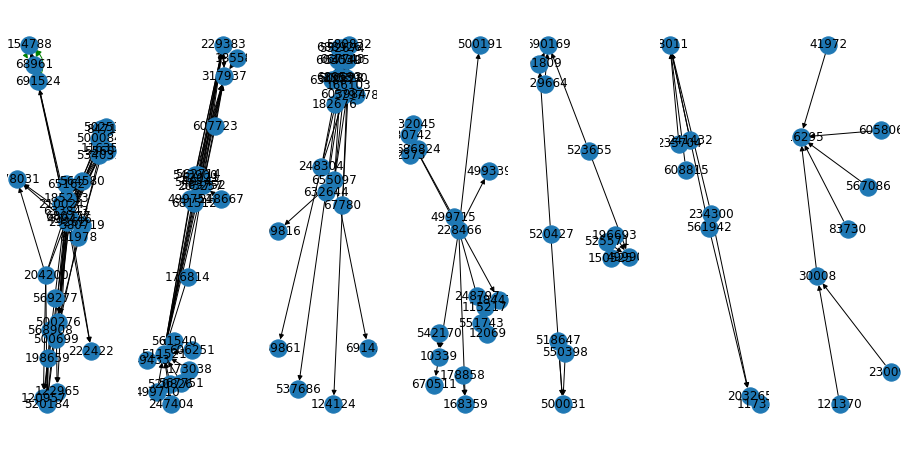

In [54]:
plt.figure(figsize=(16, 8))
lplot = len(communities)
ai = 1

for c in communities:
    gp = g_pos.subgraph(c)
    gf = G_fol.subgraph(c)
    gi = G_ign.subgraph(c)
    plt.subplot(1, lplot, ai)
    ai += 1
    positioning = nx.spring_layout(gp)
    #plt.figure(figsize=(8,4))
    nx.draw(gp, positioning, with_labels=True, arrows=True)
    nx.draw_networkx_edges(gf, positioning, edge_color="green", connectionstyle="arc3, rad=0.5" )
    nx.draw_networkx_edges(gi, positioning, edge_color="red", connectionstyle="arc3, rad=0.5" )

In [56]:
com = communities[0]

gp = g_pos.subgraph(com)
gf = G_fol.subgraph(com)
gi = G_ign.subgraph(com)

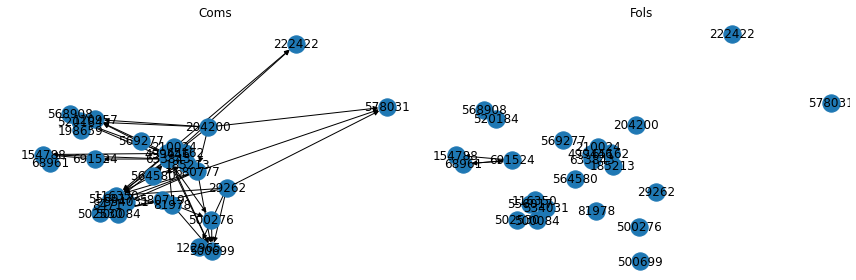

In [57]:
plt.figure(figsize=(12, 4))
limits = plt.axis("off")  # turn off axis

positioning = nx.spring_layout(gp)

plt.subplot(1, 2, 1)
nx.draw(gp, positioning, with_labels=True, arrows=True)
plt.title("Coms")

plt.subplot(1, 2, 2)
nx.draw(gf, positioning, with_labels=True, arrows=True)
plt.title("Fols")

plt.tight_layout()
plt.show()


[]

<Figure size 432x288 with 0 Axes>

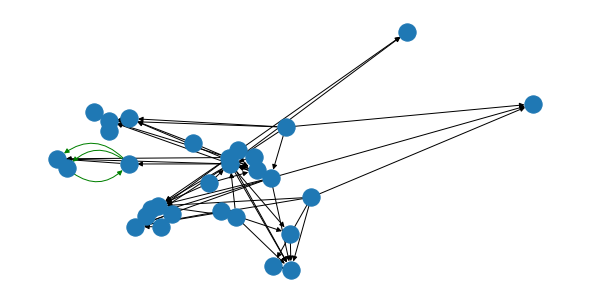

In [58]:
plt.clf()
#positioning = nx.spring_layout(gp)
plt.figure(figsize=(8,4))
nx.draw(gp, positioning, with_labels=False, arrows=True)
nx.draw_networkx_edges(gf, positioning, edge_color="green", connectionstyle="arc3, rad=0.5" )
nx.draw_networkx_edges(gi, positioning, edge_color="red", connectionstyle="arc3, rad=0.5" )